In [ ]:
#mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
!pwd

/content


In [ ]:
#!unzip '/content/drive/My Drive/my_project/Dataset.zip' -d '/content/drive/My Drive/my_project'

Archive:  /content/drive/My Drive/my_project/Dataset.zip
   creating: /content/drive/My Drive/my_project/Dataset/
   creating: /content/drive/My Drive/my_project/Dataset/plastics/
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/b6b3cbad18.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/73fb2740f1.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/ca0fcc6f65.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/89e09f25b1.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/db8b82588a.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/3db66e16e8.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/f91be9f67a.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/132e0fcd5e.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/d6364157e6.jpg  
  inflating: /content/drive/My Drive/my_project/Dataset/plastics/158cc587c3.jpg  


In [ ]:
#import pakages
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
import cv2
import matplotlib.pyplot as plt
import datetime
import numpy as np
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.constraints import max_norm
%load_ext tensorboard

In [ ]:
#Load dataset

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

train_generator = train_datagen.flow_from_directory("/content/drive/My Drive/my_project/Dataset",
                                                    batch_size = 32,
                                                    subset="training",
                                                    class_mode = 'categorical', 
                                                    target_size = (224,224))
val_generator = val_datagen.flow_from_directory("/content/drive/My Drive/my_project/Dataset",
                                                subset = "validation",
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (224,224))

Found 1108 images belonging to 7 classes.
Found 273 images belonging to 7 classes.


In [ ]:
#Transfer Learning
INPUT_SHAPE = (224,224, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

vgg_layers.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa34606f940> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa34646b080> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa34606f860> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa15eef0828> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa15f9f1fd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa34646b550> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa15eeea860> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa15eeea208> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa15eef0438> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa15eed0438> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa15eeda7b8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa15ee97

In [ ]:
# define sequential model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(Flatten())

# add dense layers with some dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(512, activation='relu'))
# add output layer
model.add(Dense(7, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

NameError: ignored

In [ ]:
EPOCHS = 50
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, 
                                               restore_best_weights=True,
                                               verbose=1)
path="/content/drive/My Drive/my_project/logs/fits"+datetime.datetime.now().strftime("%Y%M%D-%h%m%s")
tensorboard=TensorBoard(log_dir=path,histogram_freq=1)

history = model.fit(train_generator,
                    callbacks=[es_callback,tensorboard], 
                    epochs=EPOCHS, validation_data=val_generator,
                    verbose=1
                    )

Epoch 1/50
35/35 [==============================] - 26s 736ms/step - loss: 1.9469 - accuracy: 0.1913 - val_loss: 1.7471 - val_accuracy: 0.3626
Epoch 2/50
35/35 [==============================] - 25s 713ms/step - loss: 1.7599 - accuracy: 0.2987 - val_loss: 1.6154 - val_accuracy: 0.4835
Epoch 3/50
35/35 [==============================] - 25s 714ms/step - loss: 1.5209 - accuracy: 0.4413 - val_loss: 1.1920 - val_accuracy: 0.5788
Epoch 4/50
35/35 [==============================] - 25s 715ms/step - loss: 1.2652 - accuracy: 0.5505 - val_loss: 0.9994 - val_accuracy: 0.6923
Epoch 5/50
35/35 [==============================] - 25s 725ms/step - loss: 1.0792 - accuracy: 0.6300 - val_loss: 0.8893 - val_accuracy: 0.7033
Epoch 6/50
35/35 [==============================] - 25s 705ms/step - loss: 0.9568 - accuracy: 0.6715 - val_loss: 0.8908 - val_accuracy: 0.7106
Epoch 7/50
35/35 [==============================] - 25s 719ms/step - loss: 0.8303 - accuracy: 0.7265 - val_loss: 0.7512 - val_accuracy: 0.7546

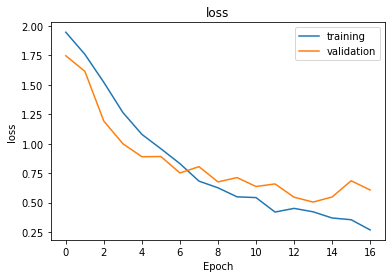

In [ ]:
#view training loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(["training","validation"])
plt.show()

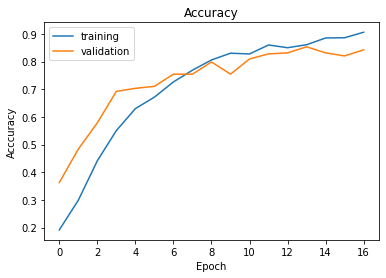

In [ ]:
#view Accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acccuracy")
plt.legend(["training","validation"])
plt.show()

In [ ]:
model.save('/content/drive/My Drive/my_project/model.h5')

In [ ]:
!cd '/content/drive/My Drive/my_project'

In [ ]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-11-10 14:40:58.562225: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT]
                   [--